In [1]:
from autometrics.dataset.datasets.simplification import SimpDA
from autometrics.util.analysis import display_top_5_metrics_by_validation, get_top_metric_by_validation, plot_metric_target_scatterplot
from autometrics.evaluate.correlation import calculate_correlation
from autometrics.aggregator.regression.PLS import PLS
from autometrics.aggregator.regression import Ridge, ElasticNet, Lasso, RandomForest, GradientBoosting, Linear
from autometrics.aggregator.regression.BudgetRegression import BudgetRegression
from autometrics.generator.llm_judge_proposer import LLMJudgeProposer
from autometrics.metrics.MetricBank import all_metrics
import dspy

/opt/miniconda3/envs/auto_eval/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = SimpDA()

In [3]:
dataset.add_metrics(all_metrics)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 41/41 [02:55<00:00,  4.29s/it]


computing greedy matching.


100%|██████████| 68/68 [00:01<00:00, 60.03it/s]


done in 177.12 seconds, 24.50 sentences/sec


In [4]:
train, dev, test = dataset.get_splits(train_ratio=0.2, val_ratio=0.3, seed=42)

In [5]:
llama31_70b = dspy.LM("openai/meta-llama/Meta-Llama-3-70b-Instruct", api_base="http://jagupard34:7410/v1", api_key="None")

dspy.settings.configure(lm=llama31_70b)

In [6]:
generator = LLMJudgeProposer(train_dataset=train, task_description="Given a complicated original sentence, simplify it in a way such that a broader audience could easily understand it.", proposer_model=llama31_70b, judge_model=llama31_70b)

In [7]:
llama31_70b.model

'openai/meta-llama/Meta-Llama-3-70b-Instruct'

In [ ]:
for target_column in dataset.target_columns:
    new_metrics = generator.generate(train, target_column)
    train.add_metrics(new_metrics)
    dev.add_metrics(new_metrics)
    test.add_metrics(new_metrics)

In [9]:
print(new_metrics)

[Preservation of original meaning_Meta-Llama-3-70b-Instruct: **Preservation of original meaning**: The ability of the model to preserve the original meaning of the sentence while simplifying it., Grammatical correctness_Meta-Llama-3-70b-Instruct: **Grammatical correctness**: The model's ability to produce grammatically correct simplified sentences., Simplification of vocabulary_Meta-Llama-3-70b-Instruct: **Simplification of vocabulary**: The model's ability to replace complex vocabulary with simpler alternatives., Sentence structure modification_Meta-Llama-3-70b-Instruct: **Sentence structure modification**: The model's ability to modify the sentence structure to make it easier to understand., Contextual understanding_Meta-Llama-3-70b-Instruct: **Contextual understanding**: The model's ability to understand the context of the original sentence and simplify it accordingly.]


In [10]:
from tqdm import tqdm
for target in tqdm(dataset.get_target_columns()):
    aggregator = Ridge(dataset=train, name=f'Ridge_{target}_llm')
    aggregator.ensure_dependencies(train)
    aggregator.ensure_dependencies(dev)
    aggregator.ensure_dependencies(test)

100%|██████████| 3/3 [00:00<00:00,  4.37it/s]


In [11]:
print(new_metrics)

[Preservation of original meaning_Meta-Llama-3-70b-Instruct: **Preservation of original meaning**: The ability of the model to preserve the original meaning of the sentence while simplifying it., Grammatical correctness_Meta-Llama-3-70b-Instruct: **Grammatical correctness**: The model's ability to produce grammatically correct simplified sentences., Simplification of vocabulary_Meta-Llama-3-70b-Instruct: **Simplification of vocabulary**: The model's ability to replace complex vocabulary with simpler alternatives., Sentence structure modification_Meta-Llama-3-70b-Instruct: **Sentence structure modification**: The model's ability to modify the sentence structure to make it easier to understand., Contextual understanding_Meta-Llama-3-70b-Instruct: **Contextual understanding**: The model's ability to understand the context of the original sentence and simplify it accordingly.]


In [12]:
train.get_metric_columns()

['BLEU',
 'CHRF',
 'TER',
 'GLEU',
 'SARI_P',
 'SARI_F',
 'BERTScoreP_roberta-large',
 'BERTScoreR_roberta-large',
 'BERTScoreF_roberta-large',
 'FKGL',
 'Preservation of original meaning_Meta-Llama-3-70b-Instruct',
 'Simplification of vocabulary_Meta-Llama-3-70b-Instruct',
 'Simplification of sentence structure_Meta-Llama-3-70b-Instruct',
 'Grammatical correctness_Meta-Llama-3-70b-Instruct',
 'Relevance to the original sentence_Meta-Llama-3-70b-Instruct',
 'Vocabulary simplification_Meta-Llama-3-70b-Instruct',
 'Sentence structure simplification_Meta-Llama-3-70b-Instruct',
 'Sentence structure modification_Meta-Llama-3-70b-Instruct',
 'Contextual understanding_Meta-Llama-3-70b-Instruct']

In [13]:
for target in tqdm(dataset.get_target_columns()):
    aggregator = Ridge(dataset=train, name=f'Ridge_{target}_llm')
    aggregator.learn(train, target)
    aggregator.predict(train)
    aggregator.predict(dev)
    aggregator.predict(test)

100%|██████████| 3/3 [00:00<00:00,  4.43it/s]


In [14]:
display_top_5_metrics_by_validation(dev, test, True)

,Top 1 Metric & Value,Top 2 Metric & Value,Top 3 Metric & Value,Top 4 Metric & Value,Top 5 Metric & Value
fluency,Grammatical correctness_llama70b (0.6672669809...,Rg_simplicity_llm (0.6755784038211216),Rg_meaning_llm (0.6168437771006638),Rg_fluency_llm (0.6354002096851313),BERTScoreP_roberta-large (0.5799887010646303)
meaning,Rg_meaning_llm (0.8514762079157394),Preservation of original meaning_llama70b (0.8...,Relevance to the original sentence_llama70b (0...,Sentence structure simplification_llama70b (0....,Grammatical correctness_llama70b (0.7401261082...
simplicity,Rg_simplicity_llm (0.790934057358275),Grammatical correctness_llama70b (0.7328514696...,Rg_meaning_llm (0.6951824997584622),Rg_fluency_llm (0.7419862509414751),Sentence structure modification_llama70b (0.64...


In [15]:
display_top_5_metrics_by_validation(test, test, True)

,Top 1 Metric & Value,Top 2 Metric & Value,Top 3 Metric & Value,Top 4 Metric & Value,Top 5 Metric & Value
fluency,Rg_simplicity_llm (0.6755784038211216),Grammatical correctness_llama70b (0.6672669809...,Rg_fluency_llm (0.6354002096851313),Rg_meaning_llm (0.6168437771006638),BERTScoreP_roberta-large (0.5799887010646303)
meaning,Rg_meaning_llm (0.8514762079157394),Preservation of original meaning_llama70b (0.8...,Relevance to the original sentence_llama70b (0...,BERTScoreR_roberta-large (0.7413929364907887),Rg_simplicity_llm (0.7402305011655116)
simplicity,Rg_simplicity_llm (0.790934057358275),Rg_fluency_llm (0.7419862509414751),Grammatical correctness_llama70b (0.7328514696...,Rg_meaning_llm (0.6951824997584622),Simplification of vocabulary_llama70b (0.65620...


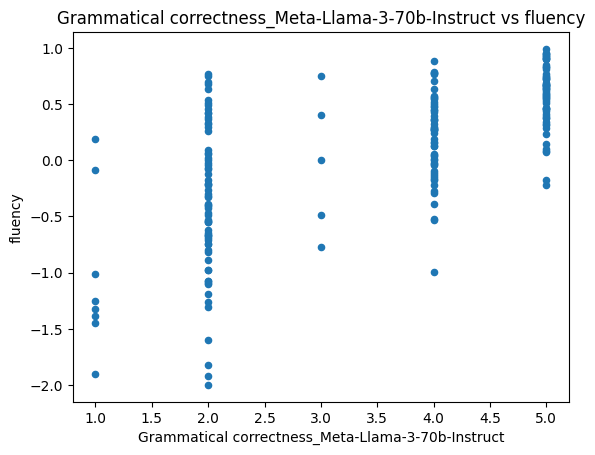

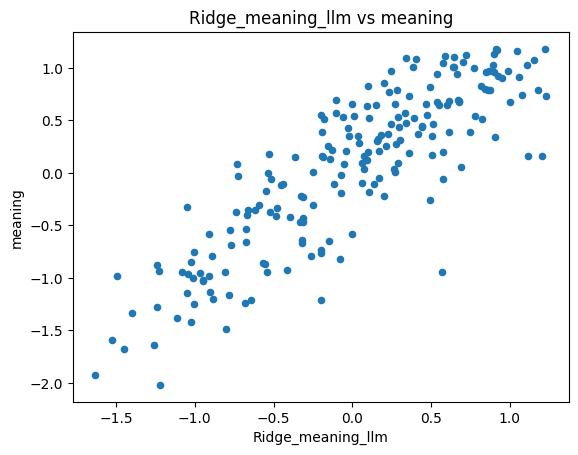

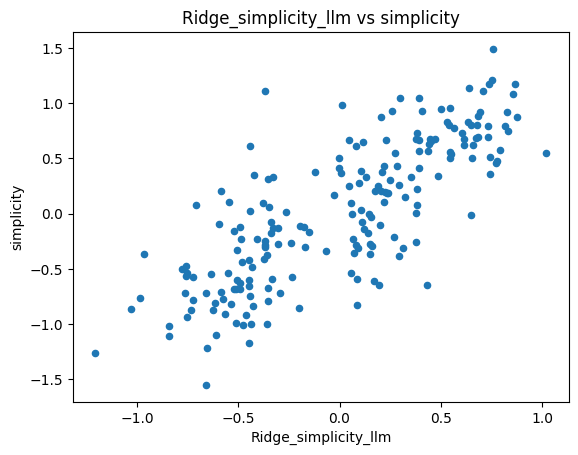

In [16]:
for target_column in dataset.target_columns:
    metric = get_top_metric_by_validation(dev, target_column, True)
    plot_metric_target_scatterplot(test, metric, target_column)
